In [1]:
# import the necessary packages
import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import cv2
import os

In [2]:
def preprocessing(path, name):
    # load the contents of the CSV annotations file
    print("[INFO] loading dataset...")
    ANNOT_PATH = path

    ANNOTS = pd.read_csv(ANNOT_PATH +'/' + name, index_col=0)
    ANNOTS['filename'] = ANNOTS['filename'].astype('string')
    ANNOTS['class'] = ANNOTS['class'].astype('string')

    ANNOTS['img_filename'] = ANNOTS.filename.str.split(pat='.',n = 1, expand = True)[0]

    ANNOTS['img_filename'] = ANNOTS['img_filename']+'.jpg'

    return ANNOTS

    

In [3]:
Running = preprocessing(config.ANNOTS_PATH, 'Running.csv')
Kicking = preprocessing(config.ANNOTS_PATH, 'Kicking.csv')
Walking = preprocessing(config.ANNOTS_PATH, 'Walking.csv')

# concat_data = pd.concat([Running, Kicking, Walking])
# concat_data.head()
# concat_data.shape

[INFO] loading dataset...
[INFO] loading dataset...
[INFO] loading dataset...


In [4]:
def img_preprocessing(path_name, name):

    imagePath = config.IMAGE_PATH+'/'+path_name + '/'+name.img_filename 
    data = []
    for path in imagePath:
        image = cv2.imread(imagePath[1])
        (h, w) = image.shape[:2]
        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = name['startX'].astype(float) / w
        startY = name['startY'].astype(float) / h
        endX = name['endX'].astype(float) / w
        endY = name['endY'].astype(float) / h

        img_cord = {'startX': startX, 'startY': startY, 'endX': endX, 'endY': endY}
        img_cord_df = pd.DataFrame(img_cord)
        # load the image and preprocess it
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)
        # update our list of data, targets, and filenames
        data.append(image)
    data = np.array(data, dtype="float32") / 255.0
    targets = img_cord_df.values.tolist()
    targets = np.array(targets, dtype="float32")
    labels = name['class'].values.tolist()
    labels = np.array(labels)   
    filenames = name.img_filename.tolist()

    return data, targets, labels, filenames


In [5]:
KICKING_np, KICK_TARGETS, KICK_LABELS, KICK_FILENAMES = img_preprocessing('Kicking',Kicking)
WALKING_np, WALK_TARGETS, WALK_LABELS, WALK_FILENAMES = img_preprocessing('Walking',Walking)
RUNNING_np, RUN_TARGETS, RUN_LABELS, RUN_FILENAMES = img_preprocessing('Running',Running)

In [6]:
DATA_np = np.concatenate((KICKING_np, WALKING_np, RUNNING_np), axis = 0)
DATA_np.shape

(2613, 224, 224, 3)

In [7]:
DATA_TARGETS  =np.concatenate((KICK_TARGETS, WALK_TARGETS, RUN_TARGETS), axis = 0)
DATA_TARGETS.shape

(2613, 4)

In [8]:
DATA_LABELS  =np.concatenate((KICK_LABELS, WALK_LABELS, RUN_LABELS), axis = 0)
DATA_LABELS.shape
# perform one-hot encoding on the labels
lb = LabelBinarizer()
LABELS = lb.fit_transform(DATA_LABELS)
if len(lb.classes_) == 2:
	LABELS = to_categorical(LABELS)

In [9]:
DATA_FILENAMES  =np.concatenate((KICK_FILENAMES, WALK_FILENAMES, RUN_FILENAMES), axis = 0)
DATA_FILENAMES.shape

(2613,)

In [10]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(DATA_np, LABELS, DATA_TARGETS, DATA_FILENAMES,test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [11]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [12]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(256, activation="relu")(flatten)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [13]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=config.INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [14]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [15]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)


[INFO] training model...
Epoch 1/30
131/131 [==============================] - 21s 82ms/step - loss: 0.5326 - bounding_box_loss: 0.0225 - class_label_loss: 0.5101 - bounding_box_accuracy: 0.8512 - class_label_accuracy: 0.8172 - val_loss: 0.1945 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 0.1846 - val_bounding_box_accuracy: 0.9331 - val_class_label_accuracy: 0.9885
Epoch 2/30
131/131 [==============================] - 8s 63ms/step - loss: 0.1397 - bounding_box_loss: 0.0058 - class_label_loss: 0.1339 - bounding_box_accuracy: 0.9426 - class_label_accuracy: 0.9828 - val_loss: 0.0736 - val_bounding_box_loss: 0.0059 - val_class_label_loss: 0.0677 - val_bounding_box_accuracy: 0.9522 - val_class_label_accuracy: 0.9885
Epoch 3/30
131/131 [==============================] - 8s 63ms/step - loss: 0.0578 - bounding_box_loss: 0.0037 - class_label_loss: 0.0542 - bounding_box_accuracy: 0.9598 - class_label_accuracy: 0.9962 - val_loss: 0.0366 - val_bounding_box_loss: 0.0046 - val_class_label

In [19]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(config.LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving object detector model...
[INFO] saving label binarizer...


In [20]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([config.PLOT_PATH, "losses.png"])
print(plotPath)
plt.savefig(plotPath)
plt.close()

../Model_Output\plots\losses.png


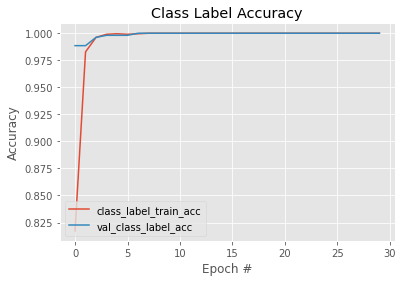

In [21]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([config.PLOT_PATH, "accs.png"])
plt.savefig(plotPath)